In [89]:
import pandas as pd
import zipfile
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings("ignore")

In [90]:
df_2021 = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2021.zip', 'r').open('TRK_13139_FY2021.csv'))
df_2022 = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2022.zip', 'r').open('TRK_13139_FY2022.csv'))
df_2023 = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2023.zip', 'r').open('TRK_13139_FY2023.csv'))
df_2024_multi = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2024_multi_reg.zip', 'r').open('TRK_13139_FY2024_multi_reg.csv'))
df_2024_single = pd.read_csv(zipfile.ZipFile('raw_data/TRK_13139_FY2024_single_reg.zip', 'r').open('TRK_13139_FY2024_single_reg.csv'))

# Shape of each dataframe

In [91]:
df_2021.shape, df_2022.shape, df_2023.shape, df_2024_multi.shape, df_2024_single.shape

((269424, 56), (301447, 56), (474421, 56), (408891, 56), (350103, 56))

# Verify that the datasets have the same column names

In [92]:
cols_2021 = set(df_2021.columns)
cols_2022 = set(df_2022.columns)
cols_2023 = set(df_2023.columns)
cols_2024_multi = set(df_2024_multi.columns)
cols_2024_single = set(df_2024_single.columns)

# Check if all column sets are equal
if cols_2021 == cols_2022 == cols_2023 == cols_2024_multi == cols_2024_single:
    print("Same column names.")
else:
    print("Different column names.")

Same column names.


# Read in and display Data Dictionary

In [93]:
dict(zip(data_dict['Column'], data_dict['Description']))

{'bcn': 'Beneficiary confirmation number. Unique ID for each registration submitted',
 'country_of_birth': "Beneficiary's country of birth",
 'country_of_nationality': "Beneficiary's country of nationality",
 'ben_date_of_birth': "Beneficiary's date of birth",
 'ben_year_of_birth': "Beneficiary's year of birth",
 'gender': "Beneficiary's gender",
 'employer_name': 'Employer name for registration',
 'FEIN': "Employer's tax number",
 'mail_addr': "Employer's mailing address",
 'city': "Employer's city",
 'state': "Employer's state",
 'zip': "Employer's zip code",
 'agent_first_name': 'First name of registered agent',
 'agent_last_name': 'Last name of registered agent',
 'lottery_year': 'Lottery year of registration',
 'status_type': 'Status of the registration. "Selected" means the registration was selected in the lottery. "Created" or "Eligible" means the registration was not selected in the lottery.',
 'ben_multi_reg_ind': 'Indicator of multiple registrations for beneficiary (a value o

In [94]:
data_dict = pd.read_excel('preprocessed_data/TRK_13139_I129_H1B_Registrations_FY21_FY24_FOIA_FIN.xlsx', sheet_name = 'Data Dictionary')

# Check difference in shape between original columns listed in data dict and columns that exist in data dict and actual dataset
print(data_dict.loc[:55, :].shape, data_dict.loc[:55, :][lambda df: df['Column'].isin(cols_2021)].shape)

# Set differences between data dict columns and data dict columns existing in H1B dataset
print(f"Data dictionary columns that don't exist in H1B dataset: {set(data_dict.loc[:55, :]['Column']) - set(data_dict.loc[:55, :][lambda df: df['Column'].isin(cols_2021)]['Column'])}")
print(f"H1B Dataset columns that do not exist in data dictionary: {set(df_2021.columns) - set(data_dict.loc[:55, :]['Column'])}")
print()
# Print out the columns that do not exist in data dictionary:
print("H1B Dataset columns that do not exist in data dictionary:")
for col in cols_2021:
    if col not in np.array(data_dict.loc[:55, :]['Column']):
        print(f"    {col}")

# Seems like that they do exist but data dict cols are uppercase and dataset cols are lowercase.
data_dict.loc[:55, :][lambda df: df['Column'].isin(cols_2021)].sort_values(by = 'Column')

(56, 2) (52, 2)
Data dictionary columns that don't exist in H1B dataset: {'VALID_TO', 'FIRST_DECISION_DATE', 'REC_DATE', 'VALID_FROM'}
H1B Dataset columns that do not exist in data dictionary: {'first_decision_date', 'rec_date', 'valid_to', 'valid_from'}

H1B Dataset columns that do not exist in data dictionary:
    first_decision_date
    rec_date
    valid_to
    valid_from


Column  \
27  BASIS_FOR_CLASSIFICATION   
50             BEN_COMP_PAID   
31      BEN_COUNTRY_OF_BIRTH   
32         BEN_CURRENT_CLASS   
47        BEN_EDUCATION_CODE   
49       BEN_PFIELD_OF_STUDY   
30                   BEN_SEX   
34       DOL_ETA_CASE_NUMBER   
51                  DOT_CODE   
48       ED_LEVEL_DEFINITION   
7                       FEIN   
19            FIRST_DECISION   
39             FULL_TIME_IND   
33                 JOB_TITLE   
52                NAICS_CODE   
29   NUMBER_OF_BENEFICIARIES   
44          NUM_OF_EMP_IN_US   
23                  PET_CITY   
24                 PET_STATE   
22                PET_STREET   
25                   PET_ZIP   
17            RECEIPT_NUMBER   
28          REQUESTED_ACTION   
26           REQUESTED_CLASS   
45                     S1Q1A   
46                     S1Q1B   
53                      S3Q1   
54                      S4Q1   
55             T_U_VAWA_FLAG   
40                  WAGE_AMT   
41                 WAGE_UNIT   
36             WORKSITE_CITY   
37            WORKSITE_STATE   
35           WORKSITE_STREET   
38              WORKSITE_ZIP   
12          agent_first_name   
13           agent_last_name   
0                        bcn   
3          ben_date_of_birth   
16         ben_multi_reg_ind   
4          ben_year_of_birth   
9                       city   
1           country_of_birth   
2     country_of_nationality   
6              employer_name   
5                     gender   
21        i129_employer_name   
14              lottery_year   
8                  mail_addr   
10                     state   
15               status_type   
11                       zip   

                                          Description  
27  Basis for Classification, as provided by the p...  
50                 Beneficiary's rate of pay per year  
31                     Beneficiary's country of birth  
32               Beneficiary's current classification  
47                       Beneficiary's education code  
49                       Beneficiary's field of study  
30                               Beneficiary's gender  
34            Unique identifier for the DOL ETA Case.  
51  Beneficiary's job code\nRefer to descriptions ...  
48  Beneficiary's education definition (descript t...  
7                               Employer's tax number  
19                         First decision of petition  
39                       Indicator for full time role  
33                            Beneficiary's job title  
52  Description of NAICS Code. See code reference ...  
29         Total number of beneficiaries for petition  
44   Number of employees in the US for the petitioner  
23                                  Petitioner's city  
24                                 Petitioner's state  
22                        Petitioner's street address  
25                              Petitioner's zip code  
17            Unique number assigned to the petition.  
28  Requested Action, as provided by the petitione...  
26                    Requested class for beneficiary  
45  Section 1, Question 1A of H-1B Supplement. Is ...  
46  Section 1, Question 1B of H-1B Supplement. Has...  
53  Section 3, Question 1 of H-1B Supplement. Type...  
54  Section 4, Question 1 of H-1B Supplement.  The...  
55  VAWA indicator,  nonblank value indicates reco...  
40                                        Wage amount  
41                                          Wage unit  
36                                      Worksite city  
37                                     Worksite state  
35                            Worksite street address  
38                                  Worksite zip code  
12                     First name of registered agent  
13                      Last name of registered agent  
0   Beneficiary confirmation number. Unique ID for...  
3                         Beneficiary's date of birth  
16  Indicator of multiple registrations for benefi...  
4                         Ben

In [95]:
col_names = data_dict.loc[:55, :][lambda df: df['Column'].isin(cols_2021)].to_dict(orient = 'list')['Column']
descriptions = data_dict.loc[:55, :][lambda df: df['Column'].isin(cols_2021)].to_dict(orient = 'list')['Description']

for i in range(len(col_names)):
    print(f"({i+1}): {col_names[i]}: {descriptions[i]}" )

(1): bcn: Beneficiary confirmation number. Unique ID for each registration submitted
(2): country_of_birth: Beneficiary's country of birth
(3): country_of_nationality: Beneficiary's country of nationality
(4): ben_date_of_birth: Beneficiary's date of birth
(5): ben_year_of_birth: Beneficiary's year of birth
(6): gender: Beneficiary's gender
(7): employer_name: Employer name for registration
(8): FEIN: Employer's tax number
(9): mail_addr: Employer's mailing address
(10): city: Employer's city
(11): state: Employer's state
(12): zip: Employer's zip code
(13): agent_first_name: First name of registered agent
(14): agent_last_name: Last name of registered agent
(15): lottery_year: Lottery year of registration
(16): status_type: Status of the registration. "Selected" means the registration was selected in the lottery. "Created" or "Eligible" means the registration was not selected in the lottery.
(17): ben_multi_reg_ind: Indicator of multiple registrations for beneficiary (a value of 1 rep

# What is the difference between multi and single registrations in 2024?

# Q: Which factors contribute most to the approval / denial of a H1B petition once it has been selected from the lottery?
Applicants are only approved or denied from an H1B petition after they were selected from the lottery. Therefore we are only interested in observations that have the **"Selected"** status type.

In [96]:
selected_status_condition = lambda df: df['status_type'] == 'SELECTED'

df_2021 = df_2021[selected_status_condition]
df_2022 = df_2022[selected_status_condition]
df_2023 = df_2023[selected_status_condition]
df_2024_multi = df_2024_multi[selected_status_condition]
df_2024_single = df_2024_single[selected_status_condition]

# Print new shapes of each dataset after filtering
df_2021.shape, df_2022.shape, df_2023.shape, df_2024_multi.shape, df_2024_single.shape

((124368, 56), (131896, 56), (127563, 56), (103060, 56), (85304, 56))

# Combine H1B datasets from 2021-2024

In [97]:
entire_df = pd.concat([df_2021, df_2022, df_2023, df_2024_multi, df_2024_single]).reset_index(drop = True)

# Cast lottery year column as int, and employer names to uppercase
entire_df['lottery_year'] = entire_df['lottery_year'].astype(int)
entire_df['employer_name'] = entire_df['employer_name'].str.upper()

# Feature preprocessing - since the following processes are deterministic and does not depend on dataset-specific statistics we can perform this on the entire dataset instead of transforming each individual split based on the attributes of the training data

### Calculate the beneficiary's age from rec_date and their ben_year_of_birth

In [103]:
# Fill in missing rec_dates with the lottery year
entire_df['rec_date'] = (entire_df['rec_date']
    .fillna(entire_df['lottery_year'])
    .astype(str).str.slice(-4)
    .astype(int)
)

# Calculate the beneficiary's age
entire_df['ben_age_in_years'] = (
    entire_df['rec_date'] 
    - entire_df['ben_year_of_birth'].astype(int)
)

### Map nationalities to their world regions, and worksite states to US geographical regions.

In [104]:
def map_countries_to_world_regions(data: pd.DataFrame) -> pd.DataFrame:
    """
    Maps country codes from the 'country_of_nationality' column to a world region such as North America, South America, etc.
    """
    country_region_mapping = {
        "CAN": "North America", "MEX": "North America", "USA": "North America", "BHS": "North America", "BRB": "North America", 
        "BLZ": "North America", "CUB": "North America", "DOM": "North America", "GRD": "North America", "HTI": "North America", 
        "HND": "North America", "JAM": "North America", "KNA": "North America", "LCA": "North America", "VCT": "North America", 
        "TTO": "North America", "PAN": "North America", "SLV": "North America", "NIC": "North America", "CRI": "North America", 
        "GTM": "North America", "ATG": "North America", "DMA": "North America",
        
        "ARG": "South America", "BOL": "South America", "BRA": "South America", "CHL": "South America", "COL": "South America", 
        "ECU": "South America", "GUY": "South America", "PRY": "South America", "PER": "South America", "SUR": "South America", 
        "URY": "South America", "VEN": "South America", 

        "ALB": "Europe", "AND": "Europe", "AUT": "Europe", "BLR": "Europe", "BEL": "Europe", "BIH": "Europe", "BGR": "Europe", 
        "HRV": "Europe", "CYP": "Europe", "CZE": "Europe", "DNK": "Europe", "EST": "Europe", "FIN": "Europe", "FRA": "Europe", 
        "DEU": "Europe", "GRC": "Europe", "HUN": "Europe", "ISL": "Europe", "IRL": "Europe", "ITA": "Europe", "XKS": "Europe", 
        "LVA": "Europe", "LIE": "Europe", "LTU": "Europe", "LUX": "Europe", "MLT": "Europe", "MDA": "Europe", "MCO": "Europe", 
        "MNE": "Europe", "NLD": "Europe", "MKD": "Europe", "NOR": "Europe", "POL": "Europe", "PRT": "Europe", "ROU": "Europe", 
        "RUS": "Europe", "SRB": "Europe", "SVK": "Europe", "SVN": "Europe", "ESP": "Europe", "SWE": "Europe", "CHE": "Europe", 
        "UKR": "Europe", "GBR": "Europe", "TUR": "Europe", "XKX": "Europe",

        "DZA": "Africa", "AGO": "Africa", "BEN": "Africa", "BWA": "Africa", "BFA": "Africa", "BDI": "Africa", "CMR": "Africa", 
        "CPV": "Africa", "CAF": "Africa", "TCD": "Africa", "CIV": "Africa", "COD": "Africa", "EGY": "Africa", "GNQ": "Africa", 
        "ERI": "Africa", "SWZ": "Africa", "ETH": "Africa", "GAB": "Africa", "GMB": "Africa", "GHA": "Africa", "GIN": "Africa", 
        "GNB": "Africa", "KEN": "Africa", "LSO": "Africa", "LBR": "Africa", "LBY": "Africa", "MDG": "Africa", "MWI": "Africa", 
        "MLI": "Africa", "MRT": "Africa", "MUS": "Africa", "MAR": "Africa", "MOZ": "Africa", "NAM": "Africa", "NER": "Africa", 
        "NGA": "Africa", "RWA": "Africa", "SEN": "Africa", "SYC": "Africa", "SLE": "Africa", "SOM": "Africa", "ZAF": "Africa", 
        "SSD": "Africa", "SDN": "Africa", "TZA": "Africa", "TGO": "Africa", "TUN": "Africa", "UGA": "Africa", "ZMB": "Africa", 
        "ZWE": "Africa", "COG": "Africa",

        "AFG": "Asia", "ARM": "Asia", "AZE": "Asia", "BHR": "Asia", "BGD": "Asia", "BTN": "Asia", "BRN": "Asia", "KHM": "Asia", 
        "CHN": "Asia", "GEO": "Asia", "HKG": "Asia", "IND": "Asia", "IDN": "Asia", "IRN": "Asia", "IRQ": "Asia", "ISR": "Asia", 
        "JPN": "Asia", "JOR": "Asia", "KAZ": "Asia", "KWT": "Asia", "KGZ": "Asia", "LAO": "Asia", "LBN": "Asia", "MAC": "Asia", 
        "MYS": "Asia", "MNG": "Asia", "MMR": "Asia", "NPL": "Asia", "PRK": "Asia", "OMN": "Asia", "PAK": "Asia", "PSE": "Asia", 
        "PHL": "Asia", "QAT": "Asia", "SAU": "Asia", "SGP": "Asia", "KOR": "Asia", "LKA": "Asia", "SYR": "Asia", "TWN": "Asia", 
        "TJK": "Asia", "THA": "Asia", "TKM": "Asia", "ARE": "Asia", "UZB": "Asia", "VNM": "Asia", "YEM": "Asia", 

        "AUS": "Oceania", "FJI": "Oceania", "NZL": "Oceania", "PNG": "Oceania", "WSM": "Oceania", "TUV": "Oceania", 

        "XXA": "Unknown", "AX1": "Unknown", "undefined": "Unknown"
    }

    result_df = data.copy()
    result_df['world_region_nationality'] = result_df['country_of_nationality'].map(country_region_mapping)
    # result_df = result_df.drop(columns = 'country_of_nationality')
    return result_df

def map_states_to_geographical_regions(data: pd.DataFrame) -> pd.DataFrame:
    """
    Maps US state/territory abbreviations from the 'worksite_state' column to a US geographical region such as Northeast, Midwest, etc.
    """
    state_region_mapping = {
        # **Northeast**
        'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
        'RI': 'Northeast', 'VT': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast',
        'PA': 'Northeast',

        # **Midwest**
        'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest',
        'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest',
        'ND': 'Midwest', 'SD': 'Midwest',

        # **South**
        'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South',
        'SC': 'South', 'VA': 'South', 'DC': 'South', 'WV': 'South', 'AL': 'South',
        'KY': 'South', 'MS': 'South', 'TN': 'South', 'TS': 'South', 'AR': 'South', 
        'LA': 'South', 'OK': 'South', 'TX': 'South',

        # **West**
        'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West', 'NM': 'West',
        'UT': 'West', 'WY': 'West', 'AK': 'West', 'CA': 'West', 'HI': 'West', 'OR': 'West',
        'WA': 'West',

        # **US Territories (Grouped Separately)**
        'PR': 'US Territory', 'GU': 'US Territory', 'VI': 'US Territory', 'AS': 'US Territory',

        # **Unknown**
        'XX': "Unknown" 
    }

    result_df = data.copy()

    # Replace missing worksite states with the corresponding value from the employer's state.
    result_df['WORKSITE_STATE'] = entire_df['WORKSITE_STATE'].fillna(entire_df['state'])

    # Map the worksite states to their US region
    result_df['WORKSITE_REGION'] = result_df['WORKSITE_STATE'].map(state_region_mapping)
    result_df = result_df.drop(columns = 'WORKSITE_STATE')
    return result_df

entire_df = map_states_to_geographical_regions(map_countries_to_world_regions(entire_df))
entire_df['world_region_nationality'].unique(), entire_df['WORKSITE_REGION'].unique()

(array(['North America', 'Asia', 'Africa', 'Europe', 'South America',
        'Oceania', 'Unknown'], dtype=object),
 array(['West', 'Northeast', 'South', 'Midwest', 'US Territory', 'Unknown'],
       dtype=object))

### Standardize all wage amounts to annual.

In [105]:
def standardize_wage_to_annual(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Cast as float, fill missing wage values with compensation paid
    df_copy['WAGE_AMT'] = (df_copy['WAGE_AMT']
        .fillna(df_copy['BEN_COMP_PAID'])
        .astype(float)
        # .dropna(subset = 'WAGE_AMT')
    )

    # Define the multiplication factors for each unit
    wage_multipliers = {
        "HOUR": 40 * 50,  # 40 hours/week * 50 weeks/year
        "MONTH": 12,      # 12 months/year
        "WEEK": 50        # 50 weeks/year
    }

    # Apply the multipliers based on the WAGE_UNIT
    df_copy['WAGE_AMT_ANNUAL'] = df_copy.apply(
        lambda row: row['WAGE_AMT'] * wage_multipliers.get(row['WAGE_UNIT'], 1) 
        if row['WAGE_UNIT'] in wage_multipliers else row['WAGE_AMT'], axis=1
    ).astype(float)

    
    # Impute missing annual wages with median wage by lottery year
    if df_copy['WAGE_AMT_ANNUAL'].isna().sum():
        median_wages_by_lottery_year = df_copy.groupby('lottery_year')['WAGE_AMT_ANNUAL'].transform('median')
        df_copy['WAGE_AMT_ANNUAL'] = df_copy['WAGE_AMT_ANNUAL'].fillna(median_wages_by_lottery_year)

    return df_copy

entire_df = standardize_wage_to_annual(entire_df)

# Ensure that there are no missing annual wage values
assert(entire_df['WAGE_AMT_ANNUAL'].isna().sum() == 0)

## Split data into train/val/test splits via time-based splitting - (2021-2023 will have training and validation while 2024 will be exclusively test split)

In [106]:
# Filter the data for the splits based on lottery_year
train_and_val_data = entire_df[entire_df['lottery_year'].isin([2021, 2022, 2023])]
test_data = entire_df[entire_df['lottery_year'] == 2024]

# Split train and validation from the filtered train_and_val_data
X_train_and_val, y_train_and_val = train_and_val_data.drop(columns="FIRST_DECISION"), train_and_val_data['FIRST_DECISION']
X_test, y_test = test_data.drop(columns="FIRST_DECISION"), test_data['FIRST_DECISION']

# Make validation split 1/3rd the size of train split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_and_val, y_train_and_val, test_size=0.33, random_state=0  # 25% for validation
)

# Output sizes of splits
print("Training Set Size:", X_train.shape[0])
print("Validation Set Size:", X_val.shape[0])
print("Test Set Size:", X_test.shape[0])

Training Set Size: 257164
Validation Set Size: 126663
Test Set Size: 188364


# 4 features to transform
1. WAGE_AMT
2. ~~JOB_TITLE~~ NAICS_CODE
3. ED_LEVEL_DEFINITION
4. ben_age_in_years

### 1. WAGE_AMT - use robust scaler to handle annual wage outliers

In [107]:
def robust_scale_annual_wage(
    X_train: pd.DataFrame, 
    X_val: pd.DataFrame, 
    X_test: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''Fit a RobustScaler on annual wage training data and transform the feature across all data splits.'''

    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()                                                
    X_test_copy = X_test.copy()

    scaler = RobustScaler()
    X_train_copy[['WAGE_AMT_ANNUAL']] = scaler.fit_transform(X_train_copy[['WAGE_AMT_ANNUAL']])
    X_val_copy[['WAGE_AMT_ANNUAL']] = scaler.transform(X_val_copy[['WAGE_AMT_ANNUAL']])
    X_test_copy[['WAGE_AMT_ANNUAL']] = scaler.transform(X_test_copy[['WAGE_AMT_ANNUAL']])

    return X_train_copy, X_val_copy, X_test_copy

X_train, X_val, X_test = robust_scale_annual_wage(X_train, X_val, X_test)

### 2. ~~JOB_TITLE~~ NAICS_CODE - Impute missing NAICS codes with existing employer name to NAICS mapping from dataset

In [108]:
# Create the mapping only on training data to avoid data leakage - we do not want training data to "know" test set information during training.
employer_name_to_naics_code_mapping = (X_train
    .dropna(subset=['NAICS_CODE'])
    .assign(NAICS_CODE=lambda df: df['NAICS_CODE'].astype(int))[['employer_name', 'NAICS_CODE']]
    .drop_duplicates()
    .set_index('employer_name')['NAICS_CODE']
    .to_dict()
)

def impute_naics(df, split_name, mapping = employer_name_to_naics_code_mapping):
    '''
    Impute missing NAICS codes in each data split (df) given the naics mapping.
    '''
    df_copy = df.copy()
    print(f"Before imputation, the # of missing NAICS codes in the training data is: {df_copy['NAICS_CODE'].isna().sum()}")

    df_copy['NAICS_CODE'] = df_copy['NAICS_CODE'].fillna(
        df_copy['employer_name'].map(mapping)
    )

    print(f"After imputation, the # of missing NAICS codes in the {split_name} data is: {df_copy['NAICS_CODE'].isna().sum()}\n")

    return df_copy['NAICS_CODE']


X_train['NAICS_CODE'] = impute_naics(X_train, split_name = 'training')
X_val['NAICS_CODE'] = impute_naics(X_val, split_name = 'validation')
X_test['NAICS_CODE'] = impute_naics(X_test, split_name = 'test')


Before imputation, the # of missing NAICS codes in the training data is: 67099
After imputation, the # of missing NAICS codes in the training data is: 7323

Before imputation, the # of missing NAICS codes in the training data is: 32839
After imputation, the # of missing NAICS codes in the validation data is: 3511

Before imputation, the # of missing NAICS codes in the training data is: 96172
After imputation, the # of missing NAICS codes in the test data is: 44691



### Impute missing NAICS Codes with 0 (Missing) and extract the first two digits from the NAICS_CODE column 

In [109]:
def preprocess_naics_codes(df: pd.DataFrame, sector_mapping: dict) -> pd.DataFrame:
    # Impute missing codes with 0 (representing missing)
    df_copy = df.copy()
    df_copy['NAICS_CODE'] = df_copy['NAICS_CODE'].fillna(0)
    
    # Extract the first two digits from the NAICS_CODE column
    df_copy['NAICS_FIRST_TWO_DIGITS'] = (df_copy['NAICS_CODE']
        .astype(int)
        .astype(str)
        .str.slice(start=0, stop=2)
        .astype(int)
    )

    # Map the first two digits of the NAICS codes to their descriptions
    df_copy['NAICS_DESC'] = df_copy['NAICS_FIRST_TWO_DIGITS'].map(sector_mapping)
    
    return df_copy

# Apply preprocessing only on each split separately
# NAICS sector definitions taken from https://www.census.gov/programs-surveys/economic-census/year/2022/guidance/understanding-naics.html
sector_mapping = {
    0: "Missing",
    11: "Agriculture, Forestry, Fishing and Hunting",
    21: "Mining, Quarrying, and Oil and Gas Extraction",
    22: "Utilities",
    23: "Construction",
    31: "Manufacturing",
    32: "Manufacturing",
    33: "Manufacturing",
    42: "Wholesale Trade",
    44: "Retail Trade",
    45: "Retail Trade",
    48: "Transportation and Warehousing",
    49: "Transportation and Warehousing",
    51: "Information",
    52: "Finance and Insurance",
    53: "Real Estate and Rental and Leasing",
    54: "Professional, Scientific, and Technical Services",
    55: "Management of Companies and Enterprises",
    56: "Administrative and Support and Waste Management and Remediation Services",
    61: "Educational Services",
    62: "Health Care and Social Assistance",
    71: "Arts, Entertainment, and Recreation",
    72: "Accommodation and Food Services",
    81: "Other Services (except Public Administration)",
    92: "Public Administration (not covered in economic census)"
}

X_train = preprocess_naics_codes(X_train, sector_mapping)
X_val = preprocess_naics_codes(X_val, sector_mapping)
X_test = preprocess_naics_codes(X_test, sector_mapping)

### 3. ED_LEVEL_DEFINITION - Impute missing values

In [110]:
def preprocess_ed_level(df: pd.DataFrame) -> pd.DataFrame:
    # Impute missing education levels with "NO CODE PROVIDED OR ILLEGIBLE"
    df_copy = df.copy()
    df_copy['ED_LEVEL_DEFINITION'] = df_copy['ED_LEVEL_DEFINITION'].fillna('NO CODE PROVIDED OR ILLEGIBLE')

    return df_copy

X_train = preprocess_ed_level(X_train)
X_val = preprocess_ed_level(X_val)
X_test = preprocess_ed_level(X_test)

### 4. ben_age_in_years - Impute values <18 and >65 with the median age

In [111]:
def impute_ben_age_in_years(
    X_train: pd.DataFrame, 
    X_val: pd.DataFrame, 
    X_test: pd.DataFrame
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Replace nonsensical ages with the median of valid ages (between 18 and 65 inclusive)
    X_train_copy = X_train.copy()
    X_val_copy = X_val.copy()                                                
    X_test_copy = X_test.copy()

    # Get the median of the valid ages in the training dataset
    valid_ages_train = X_train_copy[lambda df:
        (df['ben_age_in_years'] >= 18) & 
        (df['ben_age_in_years'] <= 65)
    ]['ben_age_in_years']
    median_age_train = valid_ages_train.median()

    # Impute invalid ages in train, val, and test splits with the median age derived from training data
    X_train_copy.loc[lambda df:
        (df['ben_age_in_years'] < 18) | 
        (df['ben_age_in_years'] > 65), 'ben_age_in_years'
    ] = median_age_train

    X_val_copy.loc[lambda df:
        (df['ben_age_in_years'] < 18) | 
        (df['ben_age_in_years'] > 65), 'ben_age_in_years'
    ] = median_age_train

    X_test_copy.loc[lambda df:
        (df['ben_age_in_years'] < 18) | 
        (df['ben_age_in_years'] > 65), 'ben_age_in_years'
    ] = median_age_train

    return X_train_copy, X_val_copy, X_test_copy

X_train, X_val, X_test = impute_ben_age_in_years(X_train, X_val, X_test)


### Select subset of main features to use for ML Model

**gender**: The gender of the beneficiary

**world_region_nationality**: The nationality of the beneficiary by world region

**WORKSITE_REGION**: The region of the worksite that the beneficiary works in by US region

**WAGE_AMT_ANNUAL**: The annual wage amount offered to the beneficiary

**NAICS_DESC**: (aka North American Industry Classification System). The description of the work sector the beneficiary works in. 

**ED_LEVEL_DEFINITION**: The education level of the beneficiary.

**ben_age_in_years**: The age of the beneficiary at the time that their petition was sent.

**FIRST_DECISION** (outcome Y): The first decision of the petition, which indicates whether it was approved or denied.


In [112]:
main_features = [
    'gender',
    'world_region_nationality',
    'WORKSITE_REGION',
    'WAGE_AMT_ANNUAL',
    'NAICS_DESC',
    'ED_LEVEL_DEFINITION',
    'ben_age_in_years'
]

X_train = X_train[main_features]
X_val = X_val[main_features]
X_test = X_test[main_features]

### Encode categorical features

In [113]:
def encode_categorical_features(train_df, val_df, test_df, features):
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    for feature in features:
        # Initialize and fit OneHotEncoder
        enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        enc.fit(train_df[[feature]])  # Fit on training data

        # Transform each split
        train_encoded = enc.transform(train_df[[feature]])
        val_encoded = enc.transform(val_df[[feature]])
        test_encoded = enc.transform(test_df[[feature]])

        # Convert arrays to DataFrames
        train_onehot = pd.DataFrame(
            train_encoded, 
            columns=enc.get_feature_names_out([feature]), index=train_df.index
        )
        val_onehot = pd.DataFrame(
            val_encoded, 
            columns=enc.get_feature_names_out([feature]), index=val_df.index
        )
        test_onehot = pd.DataFrame(
            test_encoded, 
            columns=enc.get_feature_names_out([feature]), index=test_df.index
        )

        # Concatenate encoded features
        train_df_copy = pd.concat([train_df_copy, train_onehot], axis=1)
        val_df_copy = pd.concat([val_df_copy, val_onehot], axis=1)
        test_df_copy = pd.concat([test_df_copy, test_onehot], axis=1)

    return train_df_copy, val_df_copy, test_df_copy

categorical_features = [
    'gender', 
    'world_region_nationality', 
    'WORKSITE_REGION', 
    'NAICS_DESC', 
    'ED_LEVEL_DEFINITION'
]
X_train, X_val, X_test = encode_categorical_features(X_train, X_val, X_test, categorical_features)

### Write train, val and test datasets to csv for ML modeling

In [115]:
if all(y_train.index == X_train.index):
    (pd.concat([X_train, y_train])
        .dropna(subset = 'FIRST_DECISION')
        .reset_index(drop = True)
        .to_csv('train_split.csv')
    )
if all(y_val.index == X_val.index):
    (pd.concat([X_val, y_val])
        .dropna(subset = 'FIRST_DECISION')
        .reset_index(drop = True)
        .to_csv('val_split.csv')
    )
if all(y_test.index == X_test.index):
    (pd.concat([X_test, y_test])
        .dropna(subset = 'FIRST_DECISION')
        .reset_index(drop = True)
        .to_csv('test_split.csv')
    )

### Summary statistics: TODO for entire dataset (NAICS_DESC does not exist until you added it in train/test/split), need to add it to entire-df first for proper stats reporting

In [129]:
display(X_train[['gender',
 'world_region_nationality',
 'WORKSITE_REGION',
 'NAICS_DESC',
 'ED_LEVEL_DEFINITION']].describe())

display(X_train[['WAGE_AMT_ANNUAL', 'ben_age_in_years']].describe())
# main_features

gender world_region_nationality WORKSITE_REGION  \
count   257164                   257164          257164   
unique       2                        7               6   
top       male                     Asia           South   
freq    174715                   231573           91006   

                                              NAICS_DESC  \
count                                             244856   
unique                                                21   
top     Professional, Scientific, and Technical Services   
freq                                              168038   

                  ED_LEVEL_DEFINITION  
count                          257164  
unique                             10  
top     NO CODE PROVIDED OR ILLEGIBLE  
freq                            90817

WAGE_AMT_ANNUAL  ben_age_in_years
count    257164.000000     257164.000000
mean          3.114079         31.281746
std         610.219664          5.593654
min          -4.146789         19.000000
25%          -0.467890         27.000000
50%           0.000000         30.000000
75%           0.532110         34.000000
max      302076.855642         65.000000

### Old code below: You can safely ignore

(array([3.268e+03, 1.100e+01, 2.000e+00, 0.000e+00, 3.000e+00, 4.000e+00,
        3.000e+00, 6.000e+00, 1.300e+01, 1.100e+01]),
 array([   0. ,  980.4, 1960.8, 2941.2, 3921.6, 4902. , 5882.4, 6862.8,
        7843.2, 8823.6, 9804. ]),
 <BarContainer object of 10 artists>)

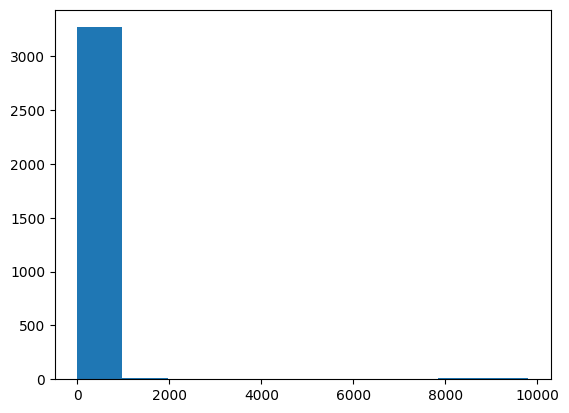

In [ ]:
plt.hist(X_train['WAGE_AMT_ANNUAL'][lambda s: s < 10000])

### Use robust scaler to handle outliers in salary

In [ ]:
## Fit and transform on the training data
# robust_scaler = RobustScaler().fit()

## Transform the validation and test data with the scaler.
# robust_scaler.transform()

# Visualize class distribution of features

In [24]:
entire_df[lambda df: df['WAGE_UNIT'] == 'HOUR'][['WAGE_AMT', 'WAGE_UNIT']]

WAGE_AMT WAGE_UNIT
191       42.24      HOUR
304       38.74      HOUR
392        35.2      HOUR
536       41.27      HOUR
558        25.0      HOUR
...         ...       ...
349227    54.55      HOUR
349702    42.46      HOUR
349810    49.55      HOUR
349970    22.95      HOUR
350077     28.0      HOUR

[9642 rows x 2 columns]

In [19]:
entire_df['BEN_PFIELD_OF_STUDY'].value_counts().head(10)

BEN_PFIELD_OF_STUDY
COMPUTER SCIENCE                    47638
INFORMATION TECHNOLOGY              10455
COMPUTER ENGINEERING                10382
ELECTRICAL ENGINEERING               9714
MECHANICAL ENGINEERING               9200
BUSINESS ADMINISTRATION              8511
COMPUTER INFORMATION SYSTEMS         8287
COMP SCI                             7279
COMPUTER APPLICATIONS                7077
COMPUTER SCIENCE AND ENGINEERING     5157
Name: count, dtype: int64

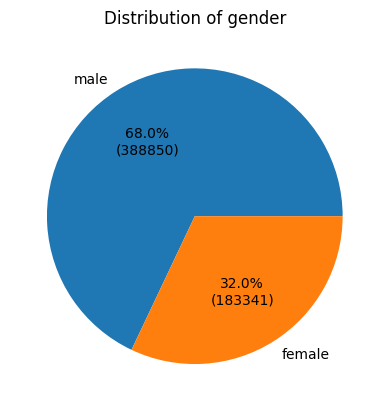

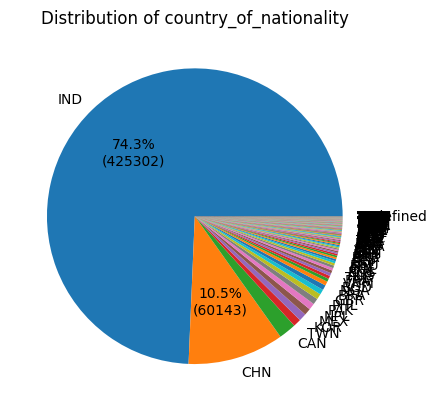

Feature employer_name has 71081 categories. Skipping visualization...


employer_name
Amazon.com Services LLC                   14470
Infosys Limited                           14268
Cognizant Technology Solutions US Corp     9511
Tata Consultancy Services Limited          9203
Google LLC                                 5424
                                          ...  
CTI and Associates Inc                        1
Motif Enterprise Inc.                         1
Atema Architecture PLLC                       1
GLOBAL Strategies, LLC                        1
Digibee Inc.                                  1
Name: count, Length: 71081, dtype: int64

Feature WAGE_AMT has 31208 categories. Skipping visualization...


WAGE_AMT
90000        2270
80000        2100
95000        1911
100000       1863
85000        1626
             ... 
120568          1
145520          1
56015           1
158888.88       1
43638.0         1
Name: count, Length: 31208, dtype: int64

Feature JOB_TITLE has 55276 categories. Skipping visualization...


JOB_TITLE
SOFTWARE ENGINEER                     19255
SOFTWARE DEVELOPER                    17126
SOFTWARE DEVELOPMENT ENGINEER I        4484
ANALYST                                2390
ARCHITECT                              2213
                                      ...  
SOFTWARE ENGINEERING SR ADVISOR           1
CHEMICAL SALES ENGINEER                   1
FSO STAFF FSRM STUCTURED FINANCE          1
ASIC CLOCKS ENGINEER HARDWARD ENGI        1
Global Chief Financial Officer            1
Name: count, Length: 55276, dtype: int64

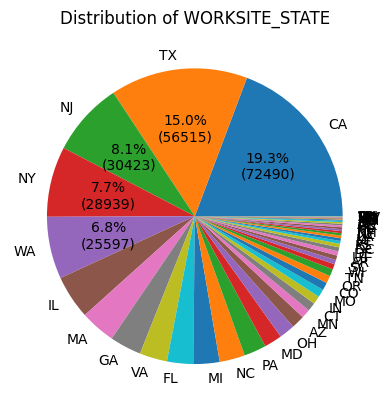

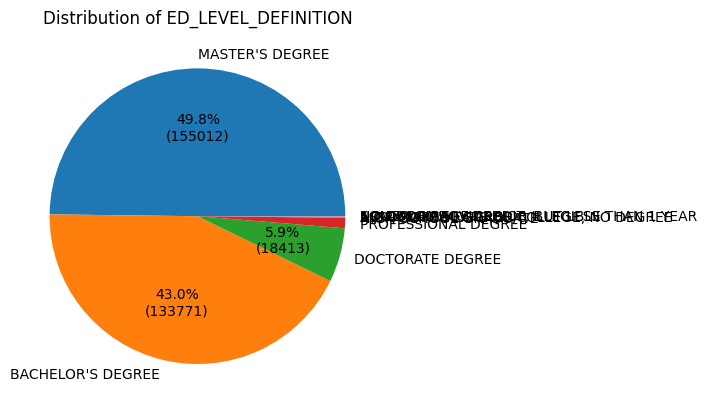

Feature BEN_PFIELD_OF_STUDY has 41353 categories. Skipping visualization...


BEN_PFIELD_OF_STUDY
COMPUTER SCIENCE                                             47638
INFORMATION TECHNOLOGY                                       10455
COMPUTER ENGINEERING                                         10382
ELECTRICAL ENGINEERING                                        9714
MECHANICAL ENGINEERING                                        9200
                                                             ...  
DUSINESS ADMINISTRATION IN MAR                                   1
BACHELOR OF ENGRG-COMP SCIENCE                                   1
INFORMATIONSYSTEMSSECURITY                                       1
CMPTR AND INFO SCI AND PHYSICS                                   1
BUSINESS ADMINISTRATION IN FINANCE AND BUSINESS ANALYTICS        1
Name: count, Length: 41353, dtype: int64

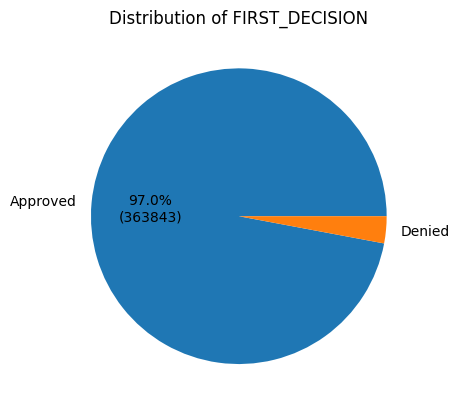

In [15]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))

        # Don't return anything if the percentage is less than ...
        if float('{:.1f}'.format(pct, v=val)) < 5:
            return None
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

for feature in main_features:
    # display(entire_df[feature].value_counts())
    s = entire_df[feature].value_counts()
    if s.shape[0] >= 200:
        print(f"Feature {feature} has {s.shape[0]} categories. Skipping visualization...")
        display(s)
        continue
    if feature not in ['WAGE_AMT', 'WAGE_UNIT']:
        plt.pie(s,labels = s.index, autopct=autopct_format(s))
        plt.title(f'Distribution of {feature}')
        plt.show()

# Count Missing Values

In [ ]:
# Count Missing Values 
entire_df_missing_vals = pd.DataFrame(entire_df[main_features].isna().sum()).reset_index().rename(columns = {"index": "Feature", 0: 'Total Missing Values'})
entire_df_missing_vals['Percentage'] = np.round((entire_df_missing_vals['Total Missing Values'] / entire_df.shape[0]) * 100, 2)
entire_df_missing_vals

In [ ]:
# Write intermediate datasets to CSV files
df_2021.to_csv('preprocessed_data/FY2021_cleaned_H1B.csv')
df_2022.to_csv('preprocessed_data/FY2022_cleaned_H1B.csv')
df_2023.to_csv('preprocessed_data/FY2023_cleaned_H1B.csv')
df_2024_multi.to_csv('preprocessed_data/FY2024_multi_reg_cleaned_H1B.csv')
df_2024_single.to_csv('preprocessed_data/FY2024_single_reg_cleaned_H1B.csv')

**Your slides should include**:
- Title, Authors

- What is the question you will be working on? Why is it interesting?


- What is the data you will be using? Include data source, size of dataset, main features to be used. Please also include summary statistics of your data.


- What prediction algorithms do you plan to use? Please describe them in detail?


- How will you evaluate your results? Please describe your chosen performance metrics and/or statistical tests in detail

In [79]:
df_2024_single['FIRST_DECISION'].unique()

array(['Denied', 'Approved', nan], dtype=object)

In [46]:
df_2021[['BEN_EDUCATION_CODE', 'ED_LEVEL_DEFINITION']].drop_duplicates()

BEN_EDUCATION_CODE                        ED_LEVEL_DEFINITION
2                       G                            MASTER'S DEGREE
11                      F                          BACHELOR'S DEGREE
13                    NaN                                        NaN
46                      I                           DOCTORATE DEGREE
441                     H                        PROFESSIONAL DEGREE
1366                    A                                 NO DIPLOMA
1775                    B                       HIGH SCHOOL GRADUATE
5686                    D      1 OR MORE YEARS OF COLLEGE, NO DEGREE
7295                    E                         ASSOCIATE'S DEGREE
132112                  J              NO CODE PROVIDED OR ILLEGIBLE
166591                  C  SOME COLLEGE CREDIT, BUT LESS THAN 1 YEAR

In [50]:
df_2021[['country_of_nationality']].drop_duplicates()

country_of_nationality
2                         CAN
4                         IND
9                         CHN
12                        VNM
24                        GHA
...                       ...
196840                    XKS
219116                    LUX
220904                    MOZ
236680                    SOM
248945                    BTN

[165 rows x 1 columns]

In [54]:
df_2021.head().drop(columns = ['bcn', 'country_of_birth', 'ben_date_of_birth', 'FEIN', 'mail_addr', 'city', 'S1Q1B', 'BEN_EDUCATION_CODE'])

country_of_nationality ben_year_of_birth  gender       employer_name state  \
2                    CAN              1988    male         Tesla, Inc.    CA   
4                    IND              1990    male   XENON INFOTEK INC    NJ   
5                    IND              1994    male  MICROSILICON, INC.    TX   
6                    IND              1994  female         Genpact LLC    NJ   
7                    IND              1996    male  DEW SOFTWARE, INC.    CA   

          zip agent_first_name agent_last_name lottery_year status_type  ...  \
2  94304-1317          Shannon   Napier Barnes         2021    SELECTED  ...   
4  08817-2436            AMITA          MISHRA         2021    SELECTED  ...   
5  77042-2829             OMAR    KULBRANDSTAD         2021    SELECTED  ...   
6  07078-2704         Abhishek      Byrapogula         2021    SELECTED  ...   
7  94539-6118           Suresh         Deopura         2021    SELECTED  ...   

  NUM_OF_EMP_IN_US S1Q1A ED_LEVEL_DEFINITION     BEN_PFIELD_OF_STUDY  \
2                0     N     MASTER'S DEGREE    COMPUTER ENGINEERING   
4                0     Y     MASTER'S DEGREE            COMPUTER SCI   
5                0     N     MASTER'S DEGREE  ELECTRICAL ENGINEERING   
6                0     N     MASTER'S DEGREE     INFORMATION SYSTEMS   
7               47     Y     MASTER'S DEGREE        COMPUTER SCIENCE   

  BEN_COMP_PAID DOT_CODE NAICS_CODE S3Q1 S4Q1 T_U_VAWA_FLAG  
2        125000      007     336111    B    N           NaN  
4         93496      NaN     541511    B    Y           NaN  
5        100000      003     541330    B    N           NaN  
6         73798      030      54161    B    Y           NaN  
7         85842      030     541511    B    Y           NaN  

[5 rows x 48 columns]

In [70]:
df_2021[['gender']].isna().sum()

gender    0
dtype: int64

In [62]:
df_2021[['BEN_COMP_PAID', 'WAGE_AMT']].isna().sum()

BEN_COMP_PAID     24390
WAGE_AMT         124368
dtype: int64

In [65]:
df_2022.shape, df_2022[['BEN_COMP_PAID', 'WAGE_AMT']].isna().sum()

((131896, 56),
 BEN_COMP_PAID     42005
 WAGE_AMT         131896
 dtype: int64)

In [66]:
df_2023.shape, df_2023[['BEN_COMP_PAID', 'WAGE_AMT']].isna().sum()

((127563, 56),
 BEN_COMP_PAID    36063
 WAGE_AMT         33548
 dtype: int64)

In [68]:
df_2024_single.shape, df_2024_single[['BEN_COMP_PAID', 'WAGE_AMT']].isna().sum()

((85304, 56),
 BEN_COMP_PAID    18032
 WAGE_AMT         16648
 dtype: int64)

In [69]:
df_2024_multi.shape, df_2024_multi[['BEN_COMP_PAID', 'WAGE_AMT']].isna().sum()

((103060, 56),
 BEN_COMP_PAID    80388
 WAGE_AMT         79596
 dtype: int64)

In [60]:
len(df_2021['JOB_TITLE'].unique())

15853